<a href="https://colab.research.google.com/github/santiric/Multicollinearity-and-clustering/blob/main/Multicollinearity_and_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Riccardo Santi* - 2182525 - *Scienze Statistiche*

# **Multicollinearity and clustering**

This is a simulation study to show how multicollinearity in the data might affect our clustering methods.

We first generate a synthetic two-dimensional dataset consisting of three artificial clusters. Each cluster is sampled from a Gaussian distribution with identical, isotropic covariance and distinct means, ensuring that the clusters are well separated in the $(x_1, x_2)$ plane but not trivially separable along a single axis. Each cluster contains 40 observations, for a total of 120 data points.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import adjusted_rand_score

np.random.seed(42)

n_per_cluster = 40
means = [(-1, -2), (1, -2), (0, 2)]
cov = [[0.4, 0], [0, 0.4]]

X = np.vstack([
    np.random.multivariate_normal(m, cov, n_per_cluster)
    for m in means
])

df = pd.DataFrame(X, columns=["x1", "x2"])
true_labels = np.repeat([0, 1, 2], n_per_cluster)

We now apply hierarchical clustering to this two-dimensional dataset and evaluate its performance using the Adjusted Rand Index. Since the data are synthetically generated, the true cluster labels are known, allowing us to perform an external validation and quantitatively assess how well the clustering recovers the underlying structure.

In [ ]:
Z_2d = linkage(df[["x1", "x2"]], method="average")
df["cluster_2d"] = fcluster(Z_2d, t=3, criterion="maxclust") - 1

ari_2d = adjusted_rand_score(true_labels, df["cluster_2d"])
print("ARI (2D clustering):", ari_2d)


ARI (2D clustering): 0.9504383763522388


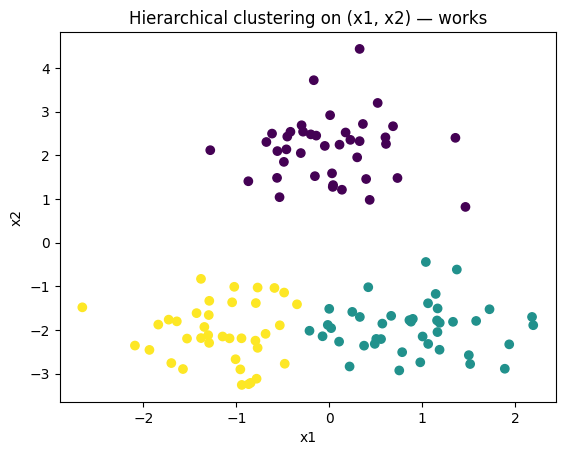

In [ ]:
plt.figure()
plt.scatter(df["x1"], df["x2"], c=df["cluster_2d"])
plt.title("Hierarchical clustering on (x1, x2) — works")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()


We obtained a clear reconstruction of the clusters

We construct a high-dimensional version of the dataset by augmenting the original two-dimensional data with 20 additional variables. Each of these new variables is almost an exact copy of x1, introducing strong multicollinearity without adding any new information. This allows us to isolate and study the effect of redundant, highly correlated features on distance-based clustering methods. In this larger dataset we apply hierarchical clustering, and then plot the result of the clustering in the $(x_1,x_2)$ plane, to see if the clusters are preserved.

In [ ]:
df_hd = df.copy()

for i in range(20):
    df_hd[f"x1_corr{i}"] = df_hd["x1"] + np.random.normal(0, 0.01, len(df_hd))


In [ ]:
Z_hd = linkage(
    df_hd.drop(columns=["cluster_2d"]),
    method="average"
)

df_hd["cluster_hd"] = fcluster(Z_hd, t=3, criterion="maxclust") - 1

ari_hd = adjusted_rand_score(true_labels, df_hd["cluster_hd"])
print("ARI (high-D with multicollinearity):", ari_hd)


ARI (high-D with multicollinearity): 0.4725901628874022


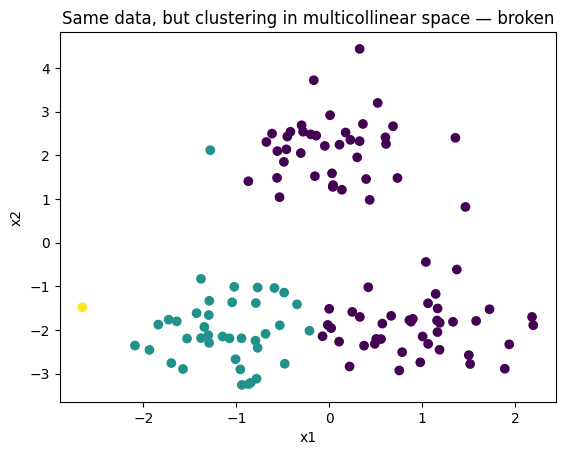

In [ ]:
plt.figure()
plt.scatter(df_hd["x1"], df_hd["x2"], c=df_hd["cluster_hd"])
plt.title("Same data, but clustering in multicollinear space — broken")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()


The clustering seems way less effective.

# Why multicollinearity breaks distance-based clustering

## 1. The baseline problem (what works)

We start with data in two dimensions:

- $x_1$
- $x_2$

Clusters are separated in **both directions**, so Euclidean distance correctly captures similarity.

In the original space, the squared Euclidean distance between two points $x$ and $y$ is

$$
\|x - y\|^2 = (x_1 - y_1)^2 + (x_2 - y_2)^2
$$

Both variables contribute **equally** to the geometry.  
Hierarchical clustering on $(x_1, x_2)$ therefore recovers the correct structure.

---

## 2. What we change: introducing multicollinearity

We now add 20 additional variables:

$$
x_{1}^{(1)}, x_{1}^{(2)}, \dots, x_{1}^{(20)}
$$

Each of them is a noisy copy of $x_1$:

$$
x_{1}^{(i)} \approx x_1 \quad \text{for } i = 1,\dots,20
$$

**Important:**  
We did *not* add new information.  
We only duplicated the same information many times.
This is the crucial point: our goal is to recover the underlying structure present in the original data, not an arbitrary distortion induced by redundant features. One could argue that the clustering obtained in the 42-dimensional space is simply an alternative representation, not intrinsically worse than the one found in two dimensions. However, this argument is weak in practice. The structure we care about is the separation between the two approximately circular clusters visible in the original $(x_1, x_2)$ space, not the separation between irregular, elongated clusters that arise only as an artifact of multicollinearity in a high-dimensional representation.

In other words, the high-dimensional clustering does not reveal new structure — it obscures the structure that was already present.

---

## 3. What the clustering algorithm actually sees

Distance-based clustering algorithms (hierarchical clustering, k-means, etc.):

- Do **not** detect redundancy
- Treat every variable as an independent axis
- Compute distances blindly in the space

In the augmented space, the squared Euclidean distance becomes approximately

$$
\|x - y\|^2
\approx
\sum_{i=0}^{20} (x_1 - y_1)^2 + (x_2 - y_2)^2
$$

which simplifies to

$$
\|x - y\|^2
\approx
21 (x_1 - y_1)^2 + (x_2 - y_2)^2
$$

---

## 4. Key insight: multicollinearity reweights the metric

Adding correlated variables does **not** just add dimensions — it **changes the metric**.

- Differences along $x_1$ are essentially counted **21 times**
- Differences along $x_2$ are counted **once**

So the clustering problem is no longer the original one.

The algorithm is now solving a **different geometric problem**.

---

## 5. What goes wrong in practice

Because distances are dominated by $x_1$:

- Points close in $x_1$ but far in $x_2$ appear *similar*
- Points close in $x_2$ but far in $x_1$ appear *dissimilar*

As a result, clusters become vertical slices in the $(x_1, x_2)$ plane and the separation along $x_2$ is effectively ignored.

This is exactly what we observe when plotting $x_1$ vs $x_2$ colored by the new clusters.

---

## 6. This is *not* the curse of dimensionality

The curse of dimensionality refers to a collection of phenomena that arise when analyzing data in high-dimensional spaces, such as distance concentration, sparsity, and the exponential growth of volume. Although the issue observed above might seem related—since we are increasing the dimensionality of the dataset—this is not the underlying cause.

If we were adding *independent* dimensions containing genuinely new information, the intrinsic structure of the dataset would change. In that case, the original two-cluster structure might no longer be appropriate, or it might become significantly harder to recover using simple clustering methods. Any degradation in clustering performance would then be attributable to increased complexity rather than to redundancy.

In our case, however, the added dimensions carry no new information. They are exact copies of an existing variable and therefore introduce only redundant, highly correlated features. The failure of the clustering algorithm is not due to high dimensionality itself, but to the distortion of the distance metric caused by multicollinearity. In other words, the problem is not that the space is large, but that its geometry has been artificially skewed.


---

## 7. Practical warning

Even though this example makes the effect appear obvious, in real-world datasets the situation is often reversed. We frequently encounter a set of features that are potentially highly correlated. Blindly applying distance-based clustering methods in such cases can produce misleading results, because the algorithm may overweight redundant features and fail to recover the true underlying structure. Careful feature selection is therefore essential before clustering. What to include and what not might really depend on what we want to emerge by the method.





